### Load Packages

In [3]:
import pandas as pd
import numpy as np
import chardet
import re
import openpyxl
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from pattern.text.en import spelling
from pattern.text.en import suggest
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from textblob import TextBlob
import gensim
import pyLDAvis.gensim_models
import statistics as st
from scipy.stats import stats,mode
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

c:\Program Files\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
C:\Users\Admin\AppData\Local\Temp\ipykernel_6784\1843037000.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Reading Data

In [4]:
file="Diet_Data_Apr2020.csv"
df=pd.DataFrame()

def f_Read_Data(data):
    if ".csv" in data:
        import chardet
        with open(f'{data}', 'rb') as f:
            result = chardet.detect(f.readline())
        try:
            df=pd.read_csv(f'{data}', sep="\t",encoding = 'utf-8-sig')
        except:
            df=pd.read_csv(f'{data}', sep="\t", encoding = 'utf-8')
    return df

In [5]:
data= f_Read_Data(file)

## Edit Headers

In [6]:
data.reset_index(0)
data.rename(columns={'0': 'text',
                        '1': 'id',
                        '2': 'created_at',
                        '3': 'place',
                        '4': 'truncated',
                        '5': 'is_quote_status',
                        '6': 'retweeted',
                        '7': 'favorite_count',
                        '8': 'retweet_count',
                        '9': 'geo',
                        '10': 'lang',
                        '11': 'hashtags',
                        '12': 'retweeted_status_id',
                        '13': 'retweeted_status_user_id',
                        '14': 'retweeted_status_user_screen_name',
                        '15': 'retweeted_extended_tweet',
                        '16': 'user_id', #id same as 1nd column but this user id
                        '17': 'name',
                        '18': 'screen_name',
                        '19': 'followers_count',
                        '20': 'friends_count',
                        '21': 'favourites_count',
                        '22': 'listed_count',
                        '23': 'statuses_count',
                        '24': 'description',
                        '25': 'location',
                        '26': 'user_created_at', #created_at same as 2nd column but this user created_at
                        '27': 'utc_offset',
                        },inplace=True)


### Add Hashtag Count Column

In [7]:
data['hashtags']=data['hashtags'].apply(lambda x: str(x).replace("nan","bos"))
data['hashtag_count']=data['hashtags'].apply(lambda x: len(str(x).split(' ')) if(str(x)!="bos") else 0)
data.sample(1)

,text,id,created_at,place,truncated,is_quote_status,retweeted,favorite_count,retweet_count,geo,lang,hashtags,retweeted_status_id,retweeted_status_user_id,retweeted_status_user_screen_name,retweeted_extended_tweet,user_id,name,screen_name,followers_count,friends_count,favourites_count,listed_count,statuses_count,description,location,user_created_at,hashtag_count
191906,Best and Easy Fitness Plans for Busy Moms #Wor...,1252101306485006336,Mon Apr 20 05:06:29 +0000 2020,None,True,False,False,0.0,0.0,None,en,Workoutformoms Burpee Plank Lunges Fitness Exe...,NaN,NaN,NaN,NaN,2.297751e+09,Happy Health 365,happy_health365,215.0,55.0,15.0,5.0,1057.0,"Follow us for : Reasonable diets, knowledge of...",world,Sat Jan 18 11:33:53 +0000 2014\n,7


#### ID values float64. Data was corrupted by scientific numbers. Convert string...

In [8]:
cols = ['retweeted_status_user_id',"user_id","retweeted_status_id"]
for i in data[cols]:
    try:
        data[i] = data[i].apply(lambda x:"{:f}".format(float(x)))
        data[i] = data[i].apply(lambda x: str(x)[0:(str(x).find('.'))])
    except:pass

#### User created at values endswith ***"\n"*** char. cleaning...


In [9]:
try:
    data['user_created_at'] = data['user_created_at'].apply(lambda x: str(x).replace("\n",""))
except:pass

## Duplicates Drops

In [10]:

print(data.shape[0])
Del_Rows = data[(data["id"].isnull()==True) | (data["user_id"]=="na")].index
data.drop(Del_Rows,axis=0,inplace=True)
# data.drop_duplicates(['user_id','text'],inplace=True) # if u want by user+text
data.drop_duplicates(['text'],inplace=True)
print(data.shape[0])


300555
174272


## Data Summary

In [11]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=True)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_dataframe(df, head=5, tail = 5):
    print(" SHAPE ".center(82,'~'))
    print('Rows: {}'.format(df.shape[0]))
    print('Columns: {}'.format(df.shape[1]))
    print(" TYPES ".center(82,'~'))
    print(df.dtypes.T)
    print("".center(82,'~'))
    print(missing_values_analysis(df))
    print(" DESCRIBE ".center(82,'~'))
    print(data.describe().T)
    print("".center(82,'~'))
    print(' DUPLICATED VALUES '.center(83,'~'))
    print(df.duplicated().sum())
    print(" QUANTILES ".center(82,'~'))
    print(df.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

print(check_dataframe(data))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 174272
Columns: 28
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
text                                  object
id                                    object
created_at                            object
place                                 object
truncated                             object
is_quote_status                       object
retweeted                             object
favorite_count                       float64
retweet_count                        float64
geo                                   object
lang                                  object
hashtags                              object
retweeted_status_id                   object
retweeted_status_user_id              object
retweeted_status_user_screen_name     object
retweeted_extended_tweet              object
user_id                               object
name                                  object

In [14]:
def check_class(x):
    nun_df = pd.DataFrame({'Vars': x.columns,'Class': [x[i].nunique() for i in x.columns]})
    nun_df = nun_df.sort_values('Class', ascending=False)
    nun_df = nun_df.reset_index(drop=True)
    return nun_df
check_class(data)

,Vars,Class
0,text,174272
1,id,174272
2,created_at,166576
3,screen_name,133200
4,user_id,132999
5,user_created_at,132804
6,name,122783
7,description,118397
8,statuses_count,58111
9,favourites_count,48354


### Cleaning text and add column ['clean_text']

In [15]:
'''
# IF U TRY LAMBDA THIS OR DOWN FUNCTION 
# data['clean_text'] = data['text'].apply(lambda x: str(x).lower().replace(": //","://")) #https :// cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'(http|https)?://[A-Za-z0-9./]+', '', x , flags=re.MULTILINE)) # all url cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", x)) #mail adress cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: str(x).replace(".com"," ")) #.com cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'@[A-Za-z0-9]+', "", x)) # mention cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'#[A-Za-z0-9]+', "", x)) # hashtag cleaning - already have hashtag column. if we optional not delete.
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'[^A-Za-z]+', " ", x)) # alphanumeric char cleaning
# data['clean_text'] = data['clean_text'].apply(lambda x: re.sub(r'^\s+', "", x))
'''

my_stopwords=stopwords.words("english")
#sorted part part cleaning.. if u want more short codes.
def f_clean_texts(x):
    x=x.lower()
    x=x.replace(": //","://")
    x=re.sub(r'(http|https)?://[A-Za-z0-9./]+', '', x , flags=re.MULTILINE) # all url cleaning
    x=re.sub(r'[A-Za-z0-9]*@[A-Za-z]*\.?[A-Za-z0-9]*', "", x) #mail adress cleaning
    x=str(x).replace(".com"," ") #.com cleaning
    x=re.sub(r'@[A-Za-z0-9]+', "", x) # mention cleaning
    x= re.sub(r'#[A-Za-z0-9]+', "", x) # hashtag cleaning - already have hashtag column. if we optional not delete.
    x= re.sub(r'[^A-Za-z]+', " ", x) # alphanumeric char cleaning
    x= re.sub(r'^\s+', "", x)
    x=" ".join([i for i in x.split() if i not in my_stopwords])
    x=" ".join([i for i in x.split() if len(i)>1])
    return x
data['clean_text']=data['text'].apply(lambda x: f_clean_texts(str(x)))
data['description']=data['description'].apply(lambda x: f_clean_texts(str(x)))
data['name']=data['name'].apply(lambda x: f_clean_texts(str(x)))
data['clean_text'].sample(3)

<>:1: DeprecationWarning: invalid escape sequence '\.'
<>:1: DeprecationWarning: invalid escape sequence '\.'
C:\Users\Admin\AppData\Local\Temp\ipykernel_6784\3635623111.py:1: DeprecationWarning: invalid escape sequence '\.'
  '''


> after drop stopwords, use filter min 100 character

In [17]:
data=data[(data['text'].str.len()>=100)] 
print(f"Last Data Row Count: {data.shape[0]}")

Last Data Row Count: 120058


# TOKENIZE

In [18]:
# english language grammer rules - same char repeat max 2.
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

# Word Stemming
ps = PorterStemmer()
def f_stemmer(x):
    words=[]
    for i in x:
        stem_word=ps.stem(i)
        words.append(stem_word)
    return words

# Lemmatizer and similarity. türkçe'de kök değil ancak mastar ekleri vb. çıkması gibi düşünebiliriz. 
lemma = WordNetLemmatizer()
def f_lemmatizer(x):
    words=[]
    for i in x:
        i=reduce_lengthening(i)
        sug=suggest(i)
        lemma_word=lemma.lemmatize(sug[0][0])
        words.append(lemma_word)
    return words
'''
# lemmatizer and similar words edited function but many times so not use now. for sentences
'''
def f_lemmatizer_and_join(x): 
    words=str(x).split()
    new_words=[]
    for i in words:
        i=reduce_lengthening(i)
        sug=suggest(i)
        lemma_word=lemma.lemmatize(sug[0][0])
        new_words.append(lemma_word)
    sentence=' '.join(new_words)
    return sentence
'''
# similar words edited function. for sentences
'''
def f_similar_word_change(x): 
    new_words=[]
    for i in x:
        i=reduce_lengthening(i)
        sug=suggest(i)
        new_words.append(sug[0][0])
    sentence=' '.join(new_words)
    return sentence

In [19]:
'''
# IF U WANT TEST
'''
# df_asd['c1']=data['clean_text'][:5]
# print(df_asd['c1'])
# df_asd['c2']=df_asd['c1'].apply(lambda x: f_lemmatizer_and_join(x))
# print(df_asd['c2'])

'\n# IF U WANT TEST\n'

In [20]:
# merge keto & ketogen for topics ngram
data['clean_text']=data['clean_text'].apply(lambda x: str(x).replace(" keto "," ketogen ")) 

C:\Users\Admin\AppData\Local\Temp\ipykernel_6784\647816490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_text']=data['clean_text'].apply(lambda x: str(x).replace(" keto "," ketogen "))


### WORD STEMMING PROCESS

In [21]:
'''
# IF U WANT LEMMA + SIMILAR WORDS CHANGES
# data['clean_text_lemma']=data['clean_text'].apply(lambda x: f_lemmatizer_and_join(x))
# data['text_tokenize']=data['text_tokenize'].apply(lambda x: f_lemmatizer(x)) #normalize words
'''
data['text_tokenize_stem']=data['clean_text'].apply(lambda x: f_stemmer(str(x).split()))
data.sample(1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6784\4002764606.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_tokenize_stem']=data['clean_text'].apply(lambda x: f_stemmer(str(x).split()))


,text,id,created_at,place,truncated,is_quote_status,retweeted,favorite_count,retweet_count,geo,lang,hashtags,retweeted_status_id,retweeted_status_user_id,retweeted_status_user_screen_name,retweeted_extended_tweet,user_id,name,screen_name,followers_count,friends_count,favourites_count,listed_count,statuses_count,description,location,user_created_at,hashtag_count,clean_text,text_tokenize_stem
12640,@AustinKellerman @JohnsHopkins Many already ha...,1245717023935496194,Thu Apr 02 14:17:37 +0000 2020,None,True,False,False,0.0,0.0,None,en,bos,na,na,NaN,NaN,611972824,matt culver,trucker_mfc,1489.0,948.0,1241.0,6.0,27119.0,owner operator trucker supporting ooida trucke...,"Montana, USA",Mon Jun 18 20:23:00 +0000 2012,0,many already mild symptoms never even stopped ...,"[mani, alreadi, mild, symptom, never, even, st..."


### NLTK NGRAMS CREATE

In [22]:
from nltk.util import ngrams
def get_ngrams(x,n=2):
    n_grams = ngrams(x, n)
    return [ ' '.join(grams) for grams in n_grams]

data['text_tokenize_ngram']=data['text_tokenize_stem'].apply(lambda x: get_ngrams(x))

C:\Users\Admin\AppData\Local\Temp\ipykernel_6784\1708858460.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_tokenize_ngram']=data['text_tokenize_stem'].apply(lambda x: get_ngrams(x))


# **WORDCLOUD**

c:\Program Files\Python310\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Program Files\Python310\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
c:\Program Files\Python310\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Program Files\Python310\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, fo

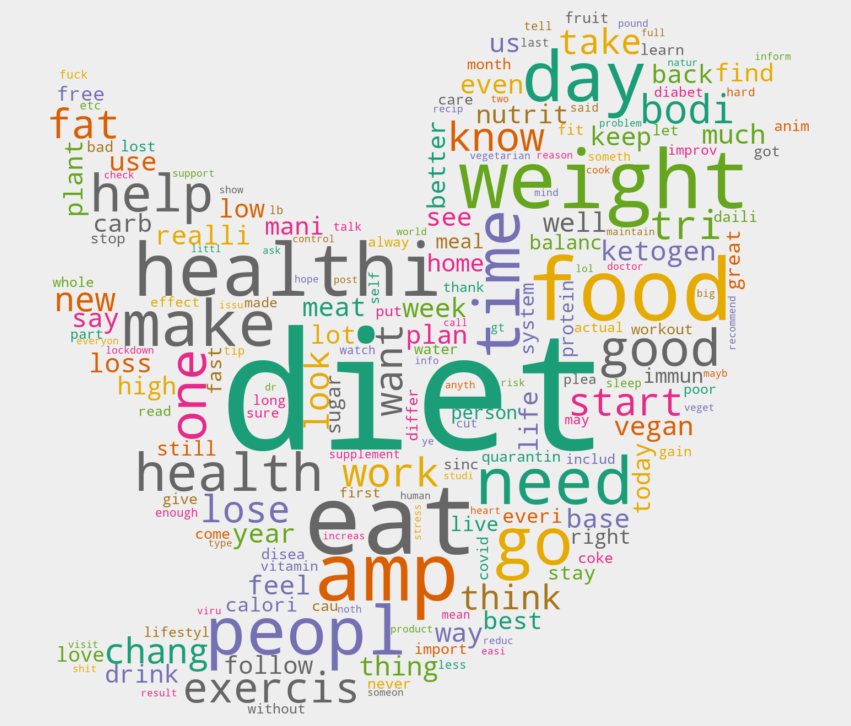

<Figure size 432x288 with 0 Axes>

In [23]:
cloud_text=[]

for i,j in data['text_tokenize_stem'].iteritems():
    for a in j:
        cloud_text.append(a+' ')
df_word_cloud=pd.DataFrame({'Head': cloud_text})
ctext =' '.join(i for i in df_word_cloud['Head'])
mask_img = np.array(Image.open("twitter.png"))
word_cloud = WordCloud(collocations=False,background_color="#eeeeee",width=1200,height=1200,mask=mask_img,mode="CMYK",colormap='Dark2').generate(ctext)
plt.figure(figsize=(15,15),facecolor="#eeeeee")
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.savefig('WordCloud_Diet.png', bbox_inches='tight')

### TEXTBLOB SENTIMENT ANALYZE

In [ ]:
# '''
# # Sentiment analysis
# '''

# df=pd.DataFrame()
# df['text']=data['clean_text'][0:20]

# df[['polarity','subjectivity']] = df['text'].apply(lambda x: pd.Series(TextBlob(str(x)).sentiment))
# for row, value in df['text'].iteritems():
#     score = SentimentIntensityAnalyzer().polarity_scores(value)
#     neg = score['neg']
#     neu = score['neu']
#     pos = score['pos']
#     com=score['compound']
#     if neg > pos :
#         df.loc[row, 'sentiment'] = "Negative"
#     elif pos > neg:
#         df.loc[row, 'sentiment'] = "Positive"
#     else:
#         df.loc[row, 'sentiment'] = "Neutral"
        
# df
# df.sentiment.value_counts().plot(kind='bar',title="sentiment analysis") 

### NLTK VADER SENTIMENT ANALYZE

,text,id,created_at,place,truncated,is_quote_status,retweeted,favorite_count,retweet_count,geo,lang,hashtags,retweeted_status_id,retweeted_status_user_id,retweeted_status_user_screen_name,retweeted_extended_tweet,user_id,name,screen_name,followers_count,friends_count,favourites_count,listed_count,statuses_count,description,location,user_created_at,hashtag_count,clean_text,text_tokenize_stem,text_tokenize_ngram,senti_scores,compound,sentiment_type
26408,@MagnificoIX @BridgetPhetasy looks like someth...,1246040341783949312,Fri Apr 03 11:42:22 +0000 2020,None,False,False,False,0.0,0.0,None,en,bos,na,na,NaN,NaN,1132732008214532096,maga bot,MPeeved,37.0,151.0,2578.0,1.0,4516.0,back shelters butthurt liberal snowflakes team...,Somewhere Really Awful,Sun May 26 19:35:30 +0000 2019,0,looks like something someone would poop eating...,"[look, like, someth, someon, would, poop, eat,...","[look like, like someth, someth someon, someon...","{'neg': 0.212, 'neu': 0.616, 'pos': 0.171, 'co...",-0.1531,Negative
72185,The #COVID19 crisis is making it tougher to ge...,1247930154288103426,Wed Apr 08 16:51:48 +0000 2020,None,True,False,False,0.0,0.0,None,en,COVID19,na,na,NaN,NaN,537454840,mcoh,oralhealthMO,625.0,438.0,384.0,24.0,1587.0,mcoh advocacy organization dedicated improving...,Missouri,Mon Mar 26 18:41:04 +0000 2012,1,crisis making tougher get routine dental care ...,"[crisi, make, tougher, get, routin, dental, ca...","[crisi make, make tougher, tougher get, get ro...","{'neg': 0.149, 'neu': 0.509, 'pos': 0.342, 'co...",0.5106,Positive
60335,🌍 World Health Day: Slimmer celebrates incredi...,1247597438334128135,Tue Apr 07 18:49:43 +0000 2020,"{'country_code': 'GB', 'url': 'https://api.twi...",True,False,False,0.0,0.0,"{'type': 'Point', 'coordinates': [51.31911209,...",en,bos,na,na,NaN,NaN,1006618329942020096,one onedietamyandsteve,one2onedietAmy,318.0,225.0,324.0,0.0,3050.0,award winning diet consultants love meeting ne...,One2onediet Amy sittingbourne,Tue Jun 12 19:24:46 +0000 2018,0,world health day slimmer celebrates incredible...,"[world, health, day, slimmer, celebr, incred, ...","[world health, health day, day slimmer, slimme...","{'neg': 0.147, 'neu': 0.735, 'pos': 0.118, 'co...",0.0258,Positive


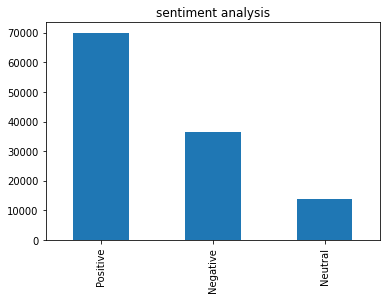

In [ ]:
sid = SentimentIntensityAnalyzer()
data['senti_scores'] = data['clean_text'].apply(lambda Twit: sid.polarity_scores(Twit))
data['compound'] = data['senti_scores'].apply(lambda x: x['compound'])
data['sentiment_type']=''
data.loc[data.compound>0,['sentiment_type']]='Positive'
data.loc[data.compound==0,'sentiment_type']='Neutral'
data.loc[data.compound<0,'sentiment_type']='Negative'
data.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")
data.sample(3)

# **LDA MODELLING**

In [ ]:
# dictionary create
tokenize_texts=data['text_tokenize_ngram']
word_list=gensim.corpora.Dictionary(tokenize_texts)

# Filter list - eliminating words that can make noise
word_list.filter_extremes(no_below=1,no_above=0.7)

# vectorization of terms
documents_matrix=[word_list.doc2bow(terim) for terim in tokenize_texts]

In [ ]:
'''
#### 10 abstract topic - num topic created
'''
lda_model = gensim.models.ldamodel.LdaModel(corpus=documents_matrix,
                                            id2word=word_list,
                                            num_topics=10,
                                            passes=10)

In [ ]:
Topics=lda_model.print_topics(num_words=10)

df=pd.DataFrame(Topics)
df.rename(columns={0: "Enum", 1: "Details"},inplace=True)
df

,Enum,Details
0,0,"0.013*""look like"" + 0.012*""drink diet"" + 0.010..."
1,1,"0.042*""plant base"" + 0.041*""base diet"" + 0.012..."
2,2,"0.026*""chang diet"" + 0.012*""immun system"" + 0...."
3,3,"0.011*""self develop"" + 0.010*""find self"" + 0.0..."
4,4,"0.020*""ketogen diet"" + 0.010*""vegetarian diet""..."
5,5,"0.038*""weight loss"" + 0.036*""lose weight"" + 0...."
6,6,"0.018*""stick diet"" + 0.013*""feel like"" + 0.009..."
7,7,"0.034*""ketogen diet"" + 0.025*""low carb"" + 0.01..."
8,8,"0.029*""diet coke"" + 0.022*""balanc diet"" + 0.00..."
9,9,"0.015*""vegan diet"" + 0.010*""food diet"" + 0.008..."


In [ ]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim_models.prepare(lda_model,documents_matrix,word_list,mds="mmds")
'''
mmds:Metrik Çok Boyutlu Ölçekleme
tsne:t-dağıtılmış Stokastik Komşu Gömme
'''
pyLDAvis.display(vis)

c:\Program Files\Python310\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


# **PIVOT TABLES**

### TOP 20 USER ORDER BY FAVORITE COUNT

In [ ]:
Name_Pivot = pd.pivot_table(data,
                                index=['user_id','screen_name'],
                                values=['text', 'favourites_count','hashtag_count','sentiment_type'],
                                aggfunc={'text': lambda x: x.count(), 'hashtag_count':'count',
                                        "favourites_count": np.sum,'sentiment_type':lambda x:(mode(x))[0][0],
                                        }).sort_values(ascending=False, by=['favourites_count']).reset_index()

top_20_names_fav_pivot=Name_Pivot[:20]
t_20_n_percentage=pd.DataFrame(top_20_names_fav_pivot.groupby('sentiment_type')['favourites_count'].agg(['sum','count']))
t_20_n_percentage['percentage']=(t_20_n_percentage['count']/t_20_n_percentage['count'].sum() * 100)

t_20_n_percentage.reset_index().to_excel('Top20_User_by_Favorite_Sent_Perc.xlsx',encoding="utf-8-sig",header=True,index=False)
# top_20_names_fav_pivot.to_excel('Top20_User_by_Favorite_Pivot.xlsx',encoding="utf-8-sig",header=True,index=False)

print(t_20_n_percentage)

### TOP 20 HASHTAGS AND SENTIMENT RESULTS

In [ ]:
'''
April 2020 hashtags interests:
1 - Covid19, World Health Day(7 April), Coronavirus - sentiment positive
2 - weight loss - negative inclined
3 - fitness motivation 
'''

tag_Pivot = pd.pivot_table(data[data['hashtags']!='bos'],
                                index=['hashtags'],
                                values=['hashtag_count','sentiment_type','compound'],
                                aggfunc={'hashtag_count':'count','sentiment_type':lambda x:(mode(x))[0][0],'compound':np.sum
                                        }).sort_values(ascending=False, by=['hashtag_count']).reset_index()
tag_df=tag_Pivot.value_counts()
tag_df=pd.DataFrame(tag_df).reset_index()
tag_df
hashlist=[]
hashlist2=[]
hashlist3=[]
for a in tag_df.index:
        for x in tag_df.loc[a,'hashtags'].lower().split():
                hashlist.append(x.strip())
                hashlist2.append(tag_df.loc[a,'hashtag_count'])
                hashlist3.append(tag_df.loc[a,'compound'])
hash_df=pd.DataFrame({'tag':hashlist,'hashcount':hashlist2,'compound':hashlist3})
del hashlist,hashlist2,hashlist3
tag_df=pd.DataFrame(hash_df.value_counts().reset_index())
tag_df=tag_df.rename(columns={0: "Count"})
tag_df
hash_df = pd.pivot_table(tag_df, index=['tag'],
                        values=['hashcount', "Count", "compound"],
                        aggfunc={"Count": np.sum, "compound": np.mean}).sort_values(ascending=False, by=["Count"]).reset_index()
del tag_df
hash_df['sentiment_type']=''
hash_df.loc[hash_df.compound>0,['sentiment_type']]='Positive'
hash_df.loc[hash_df.compound==0,'sentiment_type']='Neutral'
hash_df.loc[hash_df.compound<0,'sentiment_type']='Negative'
hash_df=hash_df[hash_df['Count']>=30]
hash_df=hash_df.sort_values(ascending=False,by=['Count']).reset_index(drop=True)
print(hash_df)
# hash_df.to_excel('HashtagsAnalysis.xlsx',encoding="utf-8-sig",header=True,index=False)